In [221]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dc_stat_think as dcst
pd.set_option('max_column', None)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from textwrap import wrap

In [2]:
item = pd.read_csv('grocery/item_to_id.csv')
display(item.head())
purchase = pd.read_csv('grocery/purchase_history.csv')
display(purchase.head())

,Item_name,Item_id
0,coffee,43
1,tea,23
2,juice,38
3,soda,9
4,sandwich loaves,39


,user_id,id
0,222087,"27,26"
1,1343649,"6,47,17"
2,404134,"18,12,23,22,27,43,38,20,35,1"
3,1110200,"9,23,2,20,26,47,37"
4,224107,"31,18,5,13,1,21,48,16,26,2,44,32,20,37,42,35,4..."


Thoughts:
* A user can buy multiple items. For example: user_id = 222087 bought two items with id=27 and 26
* I will need to split/explode the id column in the `purchase` table and then join with with the Item_id column in the `item` table to know what a user bought.
* For model training, I can just use the `purchase` table because the `item` table is just a reference table and it provides no extra details.

Let's continue to explore

In [4]:
display(item.info())
display(purchase.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Item_name  48 non-null     object
 1   Item_id    48 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 896.0+ bytes


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39474 entries, 0 to 39473
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  39474 non-null  int64 
 1   id       39474 non-null  object
dtypes: int64(1), object(1)
memory usage: 616.9+ KB


None

Thoughts:
* No columns have missing values. This is more than ideal.

In [5]:
# text data are usually very tricky with typos. So let's inspect the items further

# how many items do we have?
print('Company has', len(item['Item_name'].values), 'items.')
print()
print(item['Item_name'].values)

Company has 48 items.

['coffee' 'tea' 'juice' 'soda' 'sandwich loaves' 'dinner rolls'
 'tortillas' 'bagels' 'canned vegetables' 'spaghetti sauce' 'ketchup'
 'cheeses' 'eggs' 'milk' 'yogurt' 'butter' 'cereals' 'flour' 'sugar'
 'pasta' 'waffles' 'frozen vegetables' 'ice cream' 'poultry' 'beef' 'pork'
 'bananas' 'berries' 'cherries' 'grapefruit' 'apples' 'broccoli' 'carrots'
 'cauliflower' 'cucumbers' 'lettuce' 'laundry detergent' 'dishwashing\xa0'
 'paper towels' 'toilet paper' 'aluminum foil' 'sandwich bags' 'shampoo'
 'soap' 'hand soap' 'shaving cream' 'baby items' 'pet items']


In [6]:
# diswashing looks weird: 'diswashing\xa0'?
# let's remove the weird characters.
item['Item_name'] = item['Item_name'].str.replace('\xa0', '')
print(item['Item_name'].values)

['coffee' 'tea' 'juice' 'soda' 'sandwich loaves' 'dinner rolls'
 'tortillas' 'bagels' 'canned vegetables' 'spaghetti sauce' 'ketchup'
 'cheeses' 'eggs' 'milk' 'yogurt' 'butter' 'cereals' 'flour' 'sugar'
 'pasta' 'waffles' 'frozen vegetables' 'ice cream' 'poultry' 'beef' 'pork'
 'bananas' 'berries' 'cherries' 'grapefruit' 'apples' 'broccoli' 'carrots'
 'cauliflower' 'cucumbers' 'lettuce' 'laundry detergent' 'dishwashing'
 'paper towels' 'toilet paper' 'aluminum foil' 'sandwich bags' 'shampoo'
 'soap' 'hand soap' 'shaving cream' 'baby items' 'pet items']


# Merge two dataframes

##  Split/explode
As mentioned earlier, we'll split and then explode the `id` column in the `purchase` table

In [8]:
purchase['id_split'] = purchase['id'].str.split(',')
purchase.head()

,user_id,id,id_split
0,222087,"27,26","[27, 26]"
1,1343649,"6,47,17","[6, 47, 17]"
2,404134,"18,12,23,22,27,43,38,20,35,1","[18, 12, 23, 22, 27, 43, 38, 20, 35, 1]"
3,1110200,"9,23,2,20,26,47,37","[9, 23, 2, 20, 26, 47, 37]"
4,224107,"31,18,5,13,1,21,48,16,26,2,44,32,20,37,42,35,4...","[31, 18, 5, 13, 1, 21, 48, 16, 26, 2, 44, 32, ..."


In [9]:
# explode
purchase = purchase.explode('id_split')
purchase.head()

,user_id,id,id_split
0,222087,"27,26",27
0,222087,"27,26",26
1,1343649,"6,47,17",6
1,1343649,"6,47,17",47
1,1343649,"6,47,17",17


In [11]:
# clean up the dataframe
purchase = purchase.drop('id', axis=1)
purchase.head()

,user_id,id_split
0,222087,27
0,222087,26
1,1343649,6
1,1343649,47
1,1343649,17


In [12]:
# also reset the index
puchase = purchase.reset_index(drop=True)
purchase.head()

,user_id,id_split
0,222087,27
0,222087,26
1,1343649,6
1,1343649,47
1,1343649,17


Note:
* I've learned that when experimenting with the data, especially when trying out something I don't know for sure, it's OK to execute each line in a separate cell, followed by a print statement to see if the result set looks like what I expect.
* Don't bother grouping them into one single cell or doing cool things like chaining/piping in R.
* The code can always be refactored later.

In [13]:
# Before merging the two dataframes on'id_split' and 'Item_id', need to make sure they have the same data type
display(item.info())
display(purchase.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Item_name  48 non-null     object
 1   Item_id    48 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 896.0+ bytes


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319995 entries, 0 to 39473
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   319995 non-null  int64 
 1   id_split  319995 non-null  object
dtypes: int64(1), object(1)
memory usage: 7.3+ MB


None

In [14]:
# id_split is of type object, let's recast it to int
purchase['id_split'] = purchase['id_split'].astype('int')
display(purchase.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319995 entries, 0 to 39473
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   user_id   319995 non-null  int64
 1   id_split  319995 non-null  int64
dtypes: int64(2)
memory usage: 7.3 MB


None

In [15]:
full = purchase.merge(item, left_on='id_split', right_on='Item_id')
full = full.drop(labels=['id_split', 'Item_id'], axis=1)
display(full.head())

,user_id,Item_name
0,222087,dishwashing
1,404134,dishwashing
2,987613,dishwashing
3,60201,dishwashing
4,1166671,dishwashing


# Answer to the questions

## <span style="color:RoyalBlue"> Top 5 customer who bought the most items overall their lifetime </span>

In [26]:
item_count = \
(
    full.groupby(by=['user_id'])['Item_name']
    .agg(['count'])
    .rename(columns={'count': 'number_of_items'}) # after aggregation, 'count' becomes the column name, so rename it
    #.reset_index()                               # keep index as user_id to join with others engineered features
    .sort_values(by=['number_of_items'], ascending = False)
)

item_count.head()

,number_of_items
user_id,
269335,72
367872,70
397623,64
599172,64
377284,63


In [27]:
# Test
assert np.sum(full['user_id']==269335) == 72

## <span style="color:red"> Number of items purchased per customer and how unique the items are </span> 
I want to add a new feature, the number of unique items purchased per customer, to the dataframe above. The primary reason for this is that a customer might just purchase a single item in bulk.

In [31]:
product_data = \
(
    full.groupby(by=['user_id'])['Item_name'].agg(['count', 'nunique'])
    .rename(columns={'count': 'total_products', 'nunique': 'total_unique_products'})
    .sort_values(by=['total_products'], ascending=False)
)

product_data.head()

,total_products,total_unique_products
user_id,,
269335,72,37
367872,70,36
397623,64,36
599172,64,37
377284,63,38


In [33]:
# Test: by definition, the number of unique products should always be <= the total number of products
np.all(product_data['total_unique_products'] <= product_data['total_products'])

True

As we can see, the customer who bought the most products might not be the ones who bought the most unique products. For example, user_id = 377284 bought more different types of products than user_id = 269335, who bought the most products.

In [32]:
# which customer bought the most unique products? Hopefully, there was someone who tried out all 48 items
product_data.sort_values(by=['total_unique_products'], ascending=False).head()

,total_products,total_unique_products
user_id,,
828721,58,41
1100981,55,38
377284,63,38
1273957,51,38
897787,51,38


Thoughts:
* None of the customer has tried out all of our 48 items.
* Thus, we might care about which item is bought the most.

## <span style="color:RoyalBlue"> For each item, the customer who bought that product the most </span>
https://realpython.com/pandas-groupby/

In [34]:
# let's take a look at our data again
full.head()

,user_id,Item_name
0,222087,dishwashing
1,404134,dishwashing
2,987613,dishwashing
3,60201,dishwashing
4,1166671,dishwashing


In [36]:
# this is not correct, because it just shows: (1) how many times it was bought and 
# (2) how many unique customers that bought it.
full.groupby(by=['Item_name'])['user_id'].agg(['count', 'nunique']).head()

# on the other hand, we are asked to show the user_id that bought a particular item

,count,nunique
Item_name,,
aluminum foil,3281,3141
apples,9008,8061
baby items,3262,3124
bagels,8695,7790
bananas,8921,7994


In [39]:
# we need to deeper at the customer level
full.groupby(by=['Item_name', 'user_id'])['user_id'].agg(['count']).head()

count
Item_name     user_id       
aluminum foil 47           1
              113          1
              527          1
              553          2
              613          1

In [47]:
# test: did user_id = 47 bought aluminium one time?
np.sum((full['user_id'] == 47) & (full['Item_name']=='aluminum foil'))

1

In [49]:
# print out everything user_id = 47 purchased to make sure
full[full['user_id']==47].sort_values(by=['Item_name'])

,user_id,Item_name
224731,47,aluminum foil
319364,47,baby items
146174,47,bagels
271760,47,bananas
172206,47,broccoli
254410,47,canned vegetables
220460,47,cauliflower
235392,47,cherries
122146,47,lettuce
163810,47,milk


In [75]:
item_customer_relationship = \
(
    full.groupby(by=['Item_name', 'user_id'])['user_id']
    .agg(['count'])
    .rename(columns={'count': 'amount'})
    .reset_index()
    .sort_values(by=['Item_name', 'amount'], ascending=(True, False))
)

item_customer_relationship.head()

,Item_name,user_id,amount
306,aluminum foil,143741,3
3,aluminum foil,553,2
28,aluminum foil,13321,2
53,aluminum foil,21779,2
72,aluminum foil,33011,2


In [76]:
# but I want to get the top buy user_id for each product
rank = \
(
    item_customer_relationship.groupby(by=['Item_name'])['amount']
    .rank(ascending=False, method='dense')
    .rename('rank')
)
rank

306       1.0
3         2.0
28        2.0
53        2.0
72        2.0
         ... 
290553    3.0
290554    3.0
290555    3.0
290556    3.0
290557    3.0
Name: rank, Length: 290558, dtype: float64

In [77]:
# concatenate rank to our dataframe
item_customer_relationship = pd.concat([item_customer_relationship, rank], axis=1)
item_customer_relationship.head()

,Item_name,user_id,amount,rank
306,aluminum foil,143741,3,1.0
3,aluminum foil,553,2,2.0
28,aluminum foil,13321,2,2.0
53,aluminum foil,21779,2,2.0
72,aluminum foil,33011,2,2.0


In [78]:
# extract valuable customers: they have rank 1
valuable_customers = item_customer_relationship[item_customer_relationship['rank']==1][['Item_name', 'user_id', 'amount']]
valuable_customers.head()

,Item_name,user_id,amount
306,aluminum foil,143741,3
3694,apples,109578,4
5179,apples,384935,4
6071,apples,545108,4
10165,apples,1303742,4


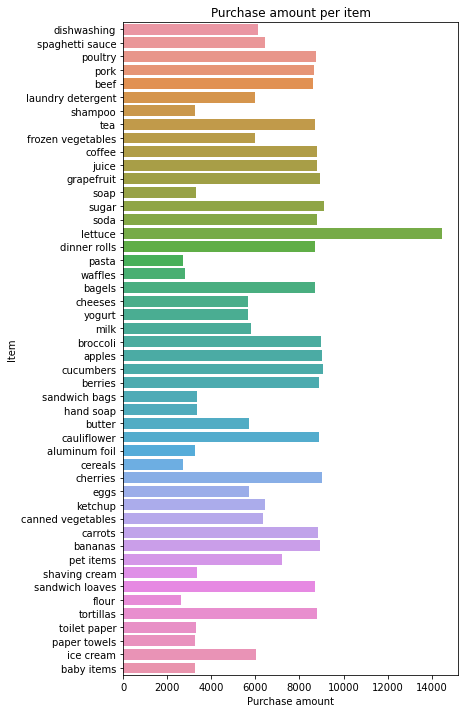

In [86]:
# finally, it's nice to visualize the number of products bought
plt.figure(figsize=(6, 12))
_ = sns.countplot(y='Item_name', data=full)
_ = plt.xlabel('Purchase amount')
_ = plt.ylabel('Item')
_ = plt.title('Purchase amount per item')

plt.show()

# Principal Component Analysis

I want to use KMeans clustering. Before I can do that, I'll need to dummify the text column `Item_data`. However, as a consequence, the dimension of my dataset will increase significantly. Thus, I need to use PCA to reduce the dimension.

## Dummify the data

In [91]:
pd.get_dummies(full['Item_name']).head()

,aluminum foil,apples,baby items,bagels,bananas,beef,berries,broccoli,butter,canned vegetables,carrots,cauliflower,cereals,cheeses,cherries,coffee,cucumbers,dinner rolls,dishwashing,eggs,flour,frozen vegetables,grapefruit,hand soap,ice cream,juice,ketchup,laundry detergent,lettuce,milk,paper towels,pasta,pet items,pork,poultry,sandwich bags,sandwich loaves,shampoo,shaving cream,soap,soda,spaghetti sauce,sugar,tea,toilet paper,tortillas,waffles,yogurt
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [92]:
item_dummies = pd.concat([full['user_id'], pd.get_dummies(full['Item_name'])], axis=1)
item_dummies.head()

,user_id,aluminum foil,apples,baby items,bagels,bananas,beef,berries,broccoli,butter,canned vegetables,carrots,cauliflower,cereals,cheeses,cherries,coffee,cucumbers,dinner rolls,dishwashing,eggs,flour,frozen vegetables,grapefruit,hand soap,ice cream,juice,ketchup,laundry detergent,lettuce,milk,paper towels,pasta,pet items,pork,poultry,sandwich bags,sandwich loaves,shampoo,shaving cream,soap,soda,spaghetti sauce,sugar,tea,toilet paper,tortillas,waffles,yogurt
0,222087,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,404134,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,987613,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,60201,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1166671,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [121]:
# let's aggregate to learn about the customer's purchases
item_data = item_dummies.groupby(by=['user_id']).agg('sum')
item_data.head()

,aluminum foil,apples,baby items,bagels,bananas,beef,berries,broccoli,butter,canned vegetables,carrots,cauliflower,cereals,cheeses,cherries,coffee,cucumbers,dinner rolls,dishwashing,eggs,flour,frozen vegetables,grapefruit,hand soap,ice cream,juice,ketchup,laundry detergent,lettuce,milk,paper towels,pasta,pet items,pork,poultry,sandwich bags,sandwich loaves,shampoo,shaving cream,soap,soda,spaghetti sauce,sugar,tea,toilet paper,tortillas,waffles,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
47,1,0,1,1,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
68,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0
113,1,1,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
123,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
223,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0


The `item_data` dataframe shows the item that each user bought. Let's take a look at user_id = 47 and come up with a few tests make sure the result set is correct.

In [136]:
# how many items that user_id = 47 purchased?
print('Use "item_data" table:', item_data.loc[47].sum())
print()
print('Use "product_data" table:', product_data['total_products'].loc[47])

Use "item_data" table: 13

Use "product_data" table: 13


In [146]:
# what items did user_id = 47 purchase
print('Use "item_data" table:')
print(item_data.loc[47][item_data.loc[47]>0].index.to_list())
print()
print('Use "full" table:')
print(sorted(full[full['user_id']==47]['Item_name'].values))

Use "item_data" table:
['aluminum foil', 'baby items', 'bagels', 'bananas', 'broccoli', 'canned vegetables', 'cauliflower', 'cherries', 'lettuce', 'milk', 'paper towels', 'pet items', 'tea']

Use "full" table:
['aluminum foil', 'baby items', 'bagels', 'bananas', 'broccoli', 'canned vegetables', 'cauliflower', 'cherries', 'lettuce', 'milk', 'paper towels', 'pet items', 'tea']


## Find the principal components
Before finding the principal components of `item_data`, we first need to normalize it.

In [148]:
scaler = StandardScaler()
item_data_scaled = scaler.fit_transform(item_data)

In [160]:
# test
print('item_data_scaled:', 'mean = {} | standard deviation = {}'
      .format(np.mean(item_data_scaled), np.std(item_data_scaled)))

item_data_scaled: mean = 5.020578569599529e-18 | standard deviation = 1.0000000000000002


In [159]:
# first two rwos rows
item_data_scaled[:2, :]

array([[ 2.44773625, -0.64659668,  2.45538737,  1.17749674,  1.15379144,
        -0.62937672, -0.63827113,  1.13382457, -0.4999061 ,  1.54009457,
        -0.63778588,  1.15662335, -0.33526286, -0.49666103,  1.13199017,
        -0.63858666, -0.64879995, -0.63138975, -0.52210626, -0.50096156,
        -0.33271327, -0.51194889, -0.6434077 , -0.3767021 , -0.51678066,
        -0.63955816, -0.53467178, -0.51252054,  0.6157092 ,  1.66111281,
         2.44270153, -0.33788156,  1.39835766, -0.63135448, -0.63357837,
        -0.37462676, -0.62812873, -0.37180647, -0.37779569, -0.37360142,
        -0.63792613, -0.5361622 , -0.65114424,  1.17651375, -0.37661648,
        -0.63242249, -0.34201571, -0.50181392],
       [-0.37173776, -0.64659668, -0.37041454, -0.6323863 , -0.64476155,
         1.18609096, -0.63827113, -0.64015999, -0.4999061 , -0.52930356,
         1.15375962, -0.64420078, -0.33526286, -0.49666103,  1.13199017,
        -0.63858666,  1.13522068, -0.63138975, -0.52210626, -0.50096156,
   

In [163]:
# fit an instance of PCA transformation
pca = PCA()
pca.fit(item_data_scaled)

PCA()

In [167]:
# test: the number of principal components <= min{observation, dimension}
pca.n_components_

48

In [166]:
# transform item_data_scaled to PCA coordinate
PC_items = pca.transform(item_data_scaled)
PC_items[:2, :]

array([[ 7.30948936e-02, -7.23931717e-02, -2.41755866e-01,
        -7.05624120e-01,  1.12800444e-01, -4.01264186e-02,
        -1.42200674e+00, -6.87675295e-01,  9.73296536e-02,
        -1.68811361e+00, -2.43606181e-01,  2.64139772e-01,
         2.34188403e+00,  1.78900628e-03,  4.10063344e-02,
         1.46471486e+00, -6.96745710e-01,  8.33932454e-01,
        -1.27513155e-01,  7.01182123e-01, -7.16086195e-02,
         1.86103792e+00,  3.27768909e-01,  1.57235605e+00,
         1.90196025e+00,  7.33790292e-01, -1.04631653e+00,
        -1.48813229e-02,  1.64716085e+00, -1.14704924e+00,
        -1.06900009e+00,  2.46969706e-01, -1.22357950e-01,
         8.03480082e-02, -4.20188774e-01,  5.16460794e-01,
         3.63899428e-01, -6.37468485e-01, -1.70958456e-02,
         2.94973393e-01, -2.81840446e+00,  1.96039119e-01,
         1.13809372e+00, -9.81076480e-02, -2.65702624e-01,
         7.30028818e-01,  7.68699983e-01,  1.04921996e-01],
       [-1.44088440e+00, -2.89482129e-01, -6.59362452e-

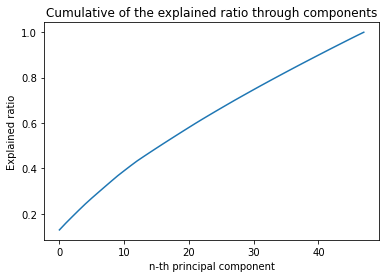

In [171]:
# observe the cumulative explained variance ratio
_ = plt.plot(np.cumsum(pca.explained_variance_ratio_))
_ = plt.xlabel('n-th principal component')
_ = plt.ylabel('Explained ratio')
_ = plt.title('Cumulative of the explained ratio through components')

It seems that by using around 35 components, we're already able to capture 80% of the variance in our dataset.

In [177]:
np.cumsum(pca.explained_variance_ratio_)[34]

0.8093012635021455

In [178]:
# refit item_data_scaled using only 34 components
pca = PCA(n_components=34, random_state=42)
PC_items = pca.fit_transform(item_data_scaled)

In [179]:
PC_items.shape

(24885, 34)

In [181]:
# for convenience, convert PC_items to a dataframe
PC_items = pd.DataFrame(PC_items)
PC_items.columns = ['PC' + str(i) for i in range(1, 35)]
PC_items.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34
0,0.073082,-0.062859,-0.268015,-0.713220,0.111387,-0.018172,-1.517593,-0.540952,0.235003,-1.713338,-0.315041,0.179327,2.240305,-0.123832,-0.014890,1.502256,-0.726710,0.861988,-0.783196,-0.504163,-0.784385,1.307993,-0.383931,0.400318,2.499529,-0.367794,-1.392285,-0.648862,1.364444,1.161299,0.935824,-0.407307,0.215957,-0.131485
1,-1.440912,-0.269197,-0.639337,-0.630591,-0.218494,0.253730,1.732744,-0.631315,-0.608564,0.236914,-0.146487,-0.804717,-0.146048,-1.093359,-0.041468,-0.581175,-0.058244,0.410244,-0.698015,1.449661,-0.217772,-0.637388,-0.183192,0.529720,0.583950,0.293273,-0.484533,0.291259,0.684889,-0.124881,0.381970,1.149926,0.826290,-0.034628
2,-0.537221,1.734168,-0.796380,1.417951,0.471174,-0.336549,-2.079497,-1.824206,0.703131,-1.157984,-0.454848,-0.592401,0.162742,-1.195797,-1.536847,1.068667,-0.680000,0.468329,2.887310,0.368655,-0.006585,-0.169305,1.157998,-0.860125,0.427567,-0.488663,-0.981229,1.420713,0.013645,-0.430249,0.660263,-0.751910,-0.141137,-0.745936
3,-2.656308,-0.337856,-0.276276,-0.330150,0.060351,-0.066924,-0.223602,-0.107373,0.181365,0.187994,2.683498,1.213746,1.157248,-0.450032,-0.275050,0.973696,0.330067,0.812884,-1.362284,-1.107742,0.410540,-0.375349,0.424948,-0.118539,0.401299,-0.513559,-0.134463,-0.150662,-0.522106,-0.249684,-0.048104,0.568729,0.065018,-0.069549
4,-0.547701,-0.194460,-1.191208,-0.265812,0.211674,1.875154,1.965303,0.118806,0.550620,0.644192,-0.909027,0.928811,0.065253,0.488660,0.398649,0.306522,-1.361493,0.475851,0.675997,0.027256,0.019820,1.112845,-0.354558,0.290852,-0.986931,0.221736,0.083412,-0.539872,-1.281915,-1.548328,-2.042029,-0.652064,0.490800,-0.789703


In [184]:
# index PC_items by user_id
PC_items.index = item_data.index
PC_items.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
47,0.073082,-0.062859,-0.268015,-0.713220,0.111387,-0.018172,-1.517593,-0.540952,0.235003,-1.713338,-0.315041,0.179327,2.240305,-0.123832,-0.014890,1.502256,-0.726710,0.861988,-0.783196,-0.504163,-0.784385,1.307993,-0.383931,0.400318,2.499529,-0.367794,-1.392285,-0.648862,1.364444,1.161299,0.935824,-0.407307,0.215957,-0.131485
68,-1.440912,-0.269197,-0.639337,-0.630591,-0.218494,0.253730,1.732744,-0.631315,-0.608564,0.236914,-0.146487,-0.804717,-0.146048,-1.093359,-0.041468,-0.581175,-0.058244,0.410244,-0.698015,1.449661,-0.217772,-0.637388,-0.183192,0.529720,0.583950,0.293273,-0.484533,0.291259,0.684889,-0.124881,0.381970,1.149926,0.826290,-0.034628
113,-0.537221,1.734168,-0.796380,1.417951,0.471174,-0.336549,-2.079497,-1.824206,0.703131,-1.157984,-0.454848,-0.592401,0.162742,-1.195797,-1.536847,1.068667,-0.680000,0.468329,2.887310,0.368655,-0.006585,-0.169305,1.157998,-0.860125,0.427567,-0.488663,-0.981229,1.420713,0.013645,-0.430249,0.660263,-0.751910,-0.141137,-0.745936
123,-2.656308,-0.337856,-0.276276,-0.330150,0.060351,-0.066924,-0.223602,-0.107373,0.181365,0.187994,2.683498,1.213746,1.157248,-0.450032,-0.275050,0.973696,0.330067,0.812884,-1.362284,-1.107742,0.410540,-0.375349,0.424948,-0.118539,0.401299,-0.513559,-0.134463,-0.150662,-0.522106,-0.249684,-0.048104,0.568729,0.065018,-0.069549
223,-0.547701,-0.194460,-1.191208,-0.265812,0.211674,1.875154,1.965303,0.118806,0.550620,0.644192,-0.909027,0.928811,0.065253,0.488660,0.398649,0.306522,-1.361493,0.475851,0.675997,0.027256,0.019820,1.112845,-0.354558,0.290852,-0.986931,0.221736,0.083412,-0.539872,-1.281915,-1.548328,-2.042029,-0.652064,0.490800,-0.789703


This is my `pca_item_data` table.

## Prep table for KMeans task

In [189]:
# join PC_items table with product_data table
pca_df = product_data.join(PC_items)
pca_df.head()

,total_products,total_unique_products,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
269335,72,37,17.534232,-4.489303,-3.124625,0.880184,-2.472791,-0.244885,-0.068999,2.222113,-0.923377,1.059312,-2.353851,2.884109,-0.792055,0.248134,2.919320,-1.247360,-3.415401,-1.553150,-1.001052,-2.334535,-1.014138,0.112735,1.585736,-0.078446,2.044381,0.315916,2.355710,4.490872,5.054723,-1.429798,2.387595,1.269683,-0.477691,1.582813
367872,70,36,16.945714,1.932501,-5.102999,0.620251,-1.780151,-4.261323,-0.930785,-0.217528,1.839568,3.977709,-1.166843,2.270824,0.273629,1.690949,6.381853,0.769505,0.402794,1.280659,0.401893,1.285826,1.405869,-1.267214,-0.201633,-2.964094,-0.026252,1.849660,0.694623,1.708504,1.224062,-3.043987,1.892184,1.467246,1.759256,3.343175
397623,64,36,15.057862,0.499689,1.367039,4.591658,-2.438559,0.362041,-2.228644,1.882743,-0.244946,3.619588,1.310677,-3.532679,-0.788803,-0.002411,0.956311,-3.183273,6.506597,1.017666,2.041039,0.211853,-3.173003,1.741286,-2.692010,-0.779505,-0.803234,-1.778463,0.085114,1.542620,4.114939,-3.689093,-1.197674,-1.902884,0.019351,-2.830464
599172,64,37,15.201620,-3.092835,5.061613,0.951064,-1.767590,-0.297315,-3.834124,-1.944807,0.841825,-1.303231,-1.510963,-2.059262,1.537950,0.806783,-3.306433,-3.311504,-1.568602,-0.420131,5.682886,-1.293193,-0.655621,0.077867,2.368906,1.219767,-0.039946,0.656857,-0.874057,0.583328,0.954974,-0.997250,-1.490398,1.512802,-0.175413,-2.008633
377284,63,38,14.820486,2.357666,-4.315779,-0.317661,-0.977982,0.791299,2.170970,-2.646883,-0.200952,-2.051766,1.198175,0.542061,0.260258,-1.628505,-1.604923,2.409935,-1.158363,0.881447,1.457280,1.523727,0.407374,1.387526,1.804462,0.606659,1.541692,0.114012,-2.371290,-1.185271,-2.508744,1.618284,-1.928913,-0.886027,1.816584,1.654136


# KMeans clustering

## Try clustering on the analytical base table

In [191]:
product_data.head()

,total_products,total_unique_products
user_id,,
269335,72,37
367872,70,36
397623,64,36
599172,64,37
377284,63,38


In [198]:
base_pipeline = make_pipeline(StandardScaler(), KMeans(n_clusters=3, random_state=42))
base_pipeline.fit(product_data)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=3, random_state=42))])

In [199]:
product_data['cluster'] = base_pipeline.predict(product_data)
product_data.head()

,total_products,total_unique_products,cluster
user_id,,,
269335,72,37,2
367872,70,36,2
397623,64,36,2
599172,64,37,2
377284,63,38,2


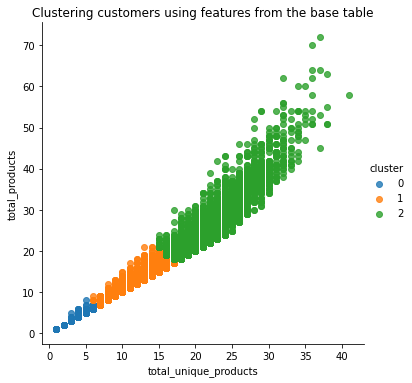

In [218]:
# visualize the clusters
_ = sns.lmplot(x='total_unique_products', y='total_products', hue='cluster', 
               data=product_data, fit_reg=False)

title = 'Clustering customers using features from the base table'
_ = plt.title(title)

plt.show()

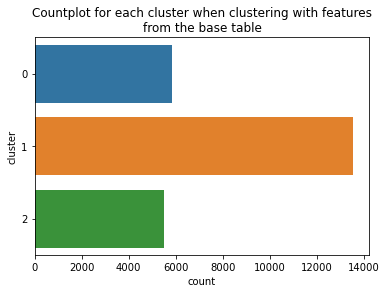

In [231]:
# I couldn't see all the clusters. I almost made an incorrect solution.
# Is there a way to adjust the opacity?

_ = sns.countplot(y='cluster', data=product_data)

title = 'Countplot for each cluster when clustering with features from the base table'
_ = plt.title('\n'.join(wrap(title, 60)))

plt.show()

Thoughts:
* Clustering customers on the analytical base table only uses two features:
    1. The total number of products a customer bought
    2. The total number of unique products a customer bought
* ~The result makes sense:~
    * ~The more unique products a customer buys, the more total products they will buy~
    * ~That's why for three clusters, we see three types of customers~
        1. ~(Low amount of unique products, low amount of total products), i.e. <span style="color:Blue"> blue customers </span>~
        2. ~(Medium amount of unique products, medium amount of total products), i.e. <span style="color:Orange"> orange customers </span>~
        3. ~(High amount of unique products, high amount of unique products), i.e. <span style="color:Green"> green customers </span>~
* The clusters seem to overlap

## Try clustering based on the tables with principle components

In [202]:
pca_pipeline = make_pipeline(StandardScaler(), KMeans(n_clusters=3, random_state=42))
pca_pipeline.fit(pca_df)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=3, random_state=42))])

In [203]:
pca_df['cluster'] = pca_pipeline.predict(pca_df)
pca_df.head()

,total_products,total_unique_products,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,cluster
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
269335,72,37,17.534232,-4.489303,-3.124625,0.880184,-2.472791,-0.244885,-0.068999,2.222113,-0.923377,1.059312,-2.353851,2.884109,-0.792055,0.248134,2.919320,-1.247360,-3.415401,-1.553150,-1.001052,-2.334535,-1.014138,0.112735,1.585736,-0.078446,2.044381,0.315916,2.355710,4.490872,5.054723,-1.429798,2.387595,1.269683,-0.477691,1.582813,1
367872,70,36,16.945714,1.932501,-5.102999,0.620251,-1.780151,-4.261323,-0.930785,-0.217528,1.839568,3.977709,-1.166843,2.270824,0.273629,1.690949,6.381853,0.769505,0.402794,1.280659,0.401893,1.285826,1.405869,-1.267214,-0.201633,-2.964094,-0.026252,1.849660,0.694623,1.708504,1.224062,-3.043987,1.892184,1.467246,1.759256,3.343175,1
397623,64,36,15.057862,0.499689,1.367039,4.591658,-2.438559,0.362041,-2.228644,1.882743,-0.244946,3.619588,1.310677,-3.532679,-0.788803,-0.002411,0.956311,-3.183273,6.506597,1.017666,2.041039,0.211853,-3.173003,1.741286,-2.692010,-0.779505,-0.803234,-1.778463,0.085114,1.542620,4.114939,-3.689093,-1.197674,-1.902884,0.019351,-2.830464,1
599172,64,37,15.201620,-3.092835,5.061613,0.951064,-1.767590,-0.297315,-3.834124,-1.944807,0.841825,-1.303231,-1.510963,-2.059262,1.537950,0.806783,-3.306433,-3.311504,-1.568602,-0.420131,5.682886,-1.293193,-0.655621,0.077867,2.368906,1.219767,-0.039946,0.656857,-0.874057,0.583328,0.954974,-0.997250,-1.490398,1.512802,-0.175413,-2.008633,0
377284,63,38,14.820486,2.357666,-4.315779,-0.317661,-0.977982,0.791299,2.170970,-2.646883,-0.200952,-2.051766,1.198175,0.542061,0.260258,-1.628505,-1.604923,2.409935,-1.158363,0.881447,1.457280,1.523727,0.407374,1.387526,1.804462,0.606659,1.541692,0.114012,-2.371290,-1.185271,-2.508744,1.618284,-1.928913,-0.886027,1.816584,1.654136,1


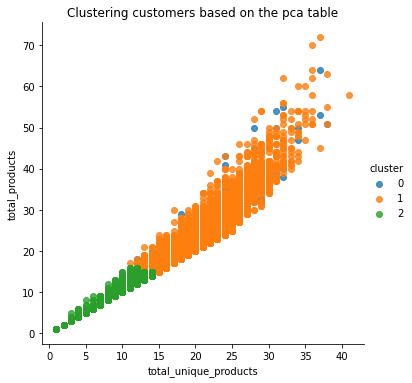

In [210]:
# visualize the clusters
_ = sns.lmplot(x='total_unique_products', y='total_products', hue='cluster', data=pca_df, fit_reg=False)

title = 'Clustering customers based on the pca table'
_ = plt.title(title)

plt.show()

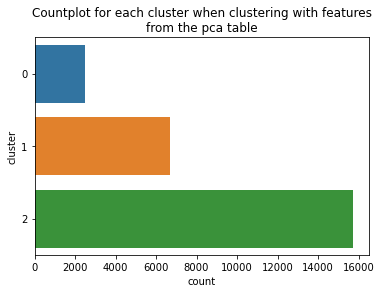

In [233]:
_ = sns.countplot(y='cluster', data=pca_df)

title = 'Countplot for each cluster when clustering with features from the pca table'
_ = plt.title('\n'.join(wrap(title, 60)))

plt.show()

Thoughts:
* The clusters seem to overlap.
* These clusters seem to be different from the ones in the base table. Let's check the adjusted rand score.

## Adjusted rand score
The adjusted rand score compares the similarity between two clusters. The closer to 0, the more independent they are. The closer to 1, the more identical they are.

In [208]:
print(adjusted_rand_score(product_data['cluster'], pca_df['cluster']))

0.26876612608405137


Thoughts:
* The clusters formed by using the features in the base table are different from the ones in the pca table.
* Neither is right nor wrong since we don't have the ground truth
* Will need to communicate to the stakeholders to know which one fit their business models.